In [ ]:
# install Hugging Face Libraries
!pip install "peft==0.2.0"
!pip install "transformers==4.27.1" "datasets==2.9.0" "accelerate==0.17.1" "evaluate==0.4.0" "bitsandbytes==0.37.1" loralib --upgrade --quiet
# install additional dependencies needed for training
!pip install rouge-score tensorboard py7zr
# ! pip install datasets transformers rouge-score nltk
! pip install datasets rouge-score nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.8/212.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.3/76.3 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

## Data preparation

In [ ]:
from datasets import load_dataset, load_metric

dataset = load_dataset('cnn_dailymail','3.0.0')

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset cnn_dailymail downloaded and prepared to /root/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights', 'id'],
        num_rows: 11490
    })
})

In [ ]:
dataset['train'][0]

{'article': 'LONDON, England (Reuters) -- Harry Potter star Daniel Radcliffe gains access to a reported £20 million ($41.1 million) fortune as he turns 18 on Monday, but he insists the money won\'t cast a spell on him. Daniel Radcliffe as Harry Potter in "Harry Potter and the Order of the Phoenix" To the disappointment of gossip columnists around the world, the young actor says he has no plans to fritter his cash away on fast cars, drink and celebrity parties. "I don\'t plan to be one of those people who, as soon as they turn 18, suddenly buy themselves a massive sports car collection or something similar," he told an Australian interviewer earlier this month. "I don\'t think I\'ll be particularly extravagant. "The things I like buying are things that cost about 10 pounds -- books and CDs and DVDs." At 18, Radcliffe will be able to gamble in a casino, buy a drink in a pub or see the horror film "Hostel: Part II," currently six places below his number one movie on the UK box office char

In [ ]:
import pandas as pd

# Concatenate the splits into one DataFrame
df = pd.DataFrame()
for split in dataset.keys():
    split_df = pd.DataFrame(dataset[split])
    split_df['split'] = split  # Optionally, keep track of the split
    df = pd.concat([df, split_df])

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

# Now df contains the entire dataset with an additional column indicating the split
df.head()

,article,highlights,id,split
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,42c027e4ff9730fbb3de84c1af0d2c506e41c3e4,train
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,ee8871b15c50d0db17b0179a6d2beab35065f1e9,train
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",06352019a19ae31e527f37f7571c6dd7f0c5da37,train
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",24521a2abb2e1f5e34e6824e0f9e56904a2b0e88,train
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",7fe70cc8b12fab2d0a258fababf7d9c6b5e1262a,train


In [ ]:
missing_values_text = df['article'].isnull().sum()
missing_values_text

0

In [ ]:
missing_values_text = df['highlights'].isnull().sum()
missing_values_text

0

In [ ]:
# Checking for empty strings or strings containing only whitespace in the 'text' column
empty_strings_count = df[df['article'].str.strip() == ''].shape[0]
empty_strings_count

0

In [ ]:
# Checking for empty strings or strings containing only whitespace in the 'text' column
empty_strings_count = df[df['highlights'].str.strip() == ''].shape[0]
empty_strings_count

0

In [ ]:
dataset = dataset.remove_columns('id')

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['article', 'highlights'],
        num_rows: 287113
    })
    validation: Dataset({
        features: ['article', 'highlights'],
        num_rows: 13368
    })
    test: Dataset({
        features: ['article', 'highlights'],
        num_rows: 11490
    })
})

In [ ]:
# Concatenate the splits into one DataFrame
df = pd.DataFrame()
for split in dataset.keys():
    split_df = pd.DataFrame(dataset[split])
    split_df['split'] = split  # Optionally, keep track of the split
    df = pd.concat([df, split_df])

# Reset the index of the DataFrame
df.reset_index(drop=True, inplace=True)

# Now df contains the entire dataset with an additional column indicating the split
df.head()

,article,highlights,split
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,train
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,train
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",train
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",train
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",train


In [ ]:
df.head(-5)

,article,highlights,split
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,train
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,train
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",train
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",train
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",train
...,...,...,...
311961,It’s been just over three years since Dana Vul...,Natalie Dimitrovska set Dana Vulin on fire at ...,test
311962,Crown Princess Mary attended an Anzac Day cere...,Australian-born Royal placed a wreath at a mem...,test
311963,George Osborne's economic record will come und...,Office for National Statistics to release grow...,test
311964,"Everyone knows the tortoise beat the hare, bu...",Amazing scene captured on film in South Africa...,test


In [ ]:
# Compute the length of text for each entry in the 'article' column
df['article_length'] = df['article'].apply(len)

# Calculate the average length of text in the 'article' column
average_length = df['article_length'].mean()

# Print the average length
print(f'The average length of text (amount of characters) in the "article" column is {average_length}')

The average length of text (amount of characters) in the "article" column is 4026.503191001728


In [ ]:
# Compute and display descriptive statistics
descriptive_stats = df['article_length'].describe()
print(descriptive_stats)

count    311971.000000
mean       4026.503191
std        1958.781868
min          48.000000
25%        2570.000000
50%        3670.000000
75%        5112.000000
max       15925.000000
Name: article_length, dtype: float64


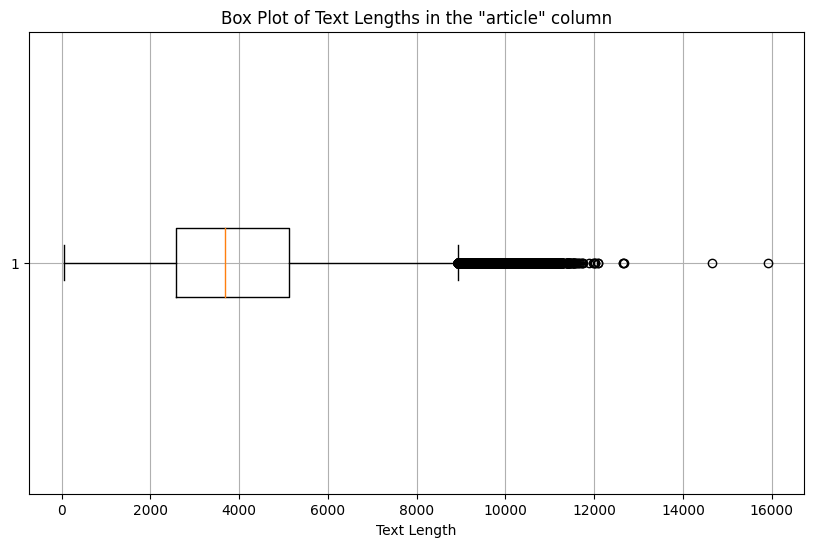

In [ ]:
import matplotlib.pyplot as plt

# Create a box plot to visually inspect outliers
plt.figure(figsize=(10,6))
plt.boxplot(df['article_length'], vert=False)
plt.title('Box Plot of Text Lengths in the "article" column')
plt.xlabel('Text Length')
plt.grid(True)
plt.show()

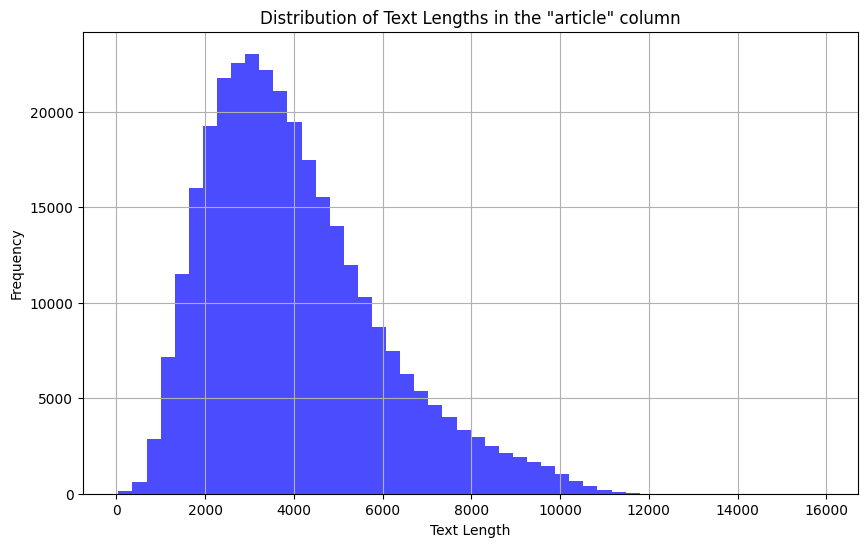

In [ ]:


# Assuming 'article_length' column is already computed as shown in previous steps
# df['article_length'] = df['article'].apply(len)

# Plotting the distribution of text lengths
plt.figure(figsize=(10,6))
plt.hist(df['article_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths in the "article" column')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
# IQR method
Q1 = df['article_length'].quantile(0.25)
Q3 = df['article_length'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['article_length'] < (Q1 - 1.5 * IQR)) | (df['article_length'] > (Q3 + 1.5 * IQR))]


In [ ]:
outliers

,article,highlights,split,article_length
30,"LONDON, England (CNN) -- Prince Harry led trib...","Prince Harry describes Princess Diana as ""the ...",train,9212
314,(CNN) -- CNN.com reader Kristy O'Connor took a...,I-Reporters share tales of meeting Heath Ledge...,train,9269
497,"If you're like us, you eat out more than ever ...",Health magazine names Top 10 chain restaurants...,train,9505
686,(CNN Student News) -- Record the CNN Special I...,Learn about autism spectrum disorders (ASD)\nE...,train,10022
999,(Mental Floss) -- There have been presidential...,President Harding's illegitimate daughter was ...,train,9528
...,...,...,...,...
311857,Tyra Banks made her awards ceremony hosting de...,"Matt Lauer donates $1,000 to charity for each ...",test,11451
311872,One of the earliest Spitfires ever to go into ...,The Mark 1 version of the iconic plane was one...,test,9674
311876,Archaeologists have uncovered a ritual burial...,"Seven human skulls, nearly 2,000 years old, ha...",test,9695
311935,It had all the trappings of a down-home countr...,Sunday's party marked the 150th anniversary of...,test,10326


In [ ]:
# Remove outliers
df_filtered = df[(df['article_length'] >= (Q1 - 1.5 * IQR)) & (df['article_length'] <= (Q3 + 1.5 * IQR))]


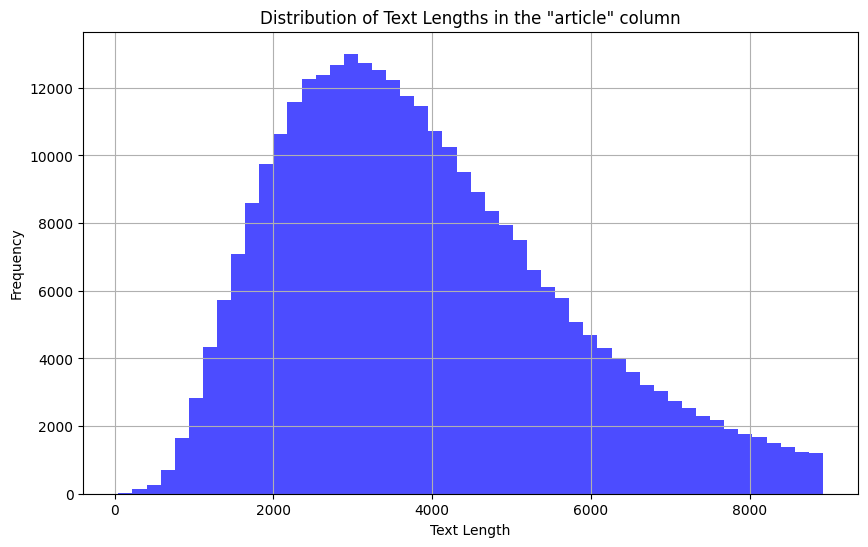

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(df_filtered['article_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Text Lengths in the "article" column')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
# Compute the length of text for each entry in the 'article' column
# df_['article_length'] = df_filtered['article'].apply(len)

# Calculate the average length of text in the 'article' column
average_length = df_filtered['article_length'].mean()

# Print the average length
print(f'The average length of text (amount of characters) in the "article" column is {average_length}')

The average length of text (amount of characters) in the "article" column is 3885.7312772870177


### Summary column

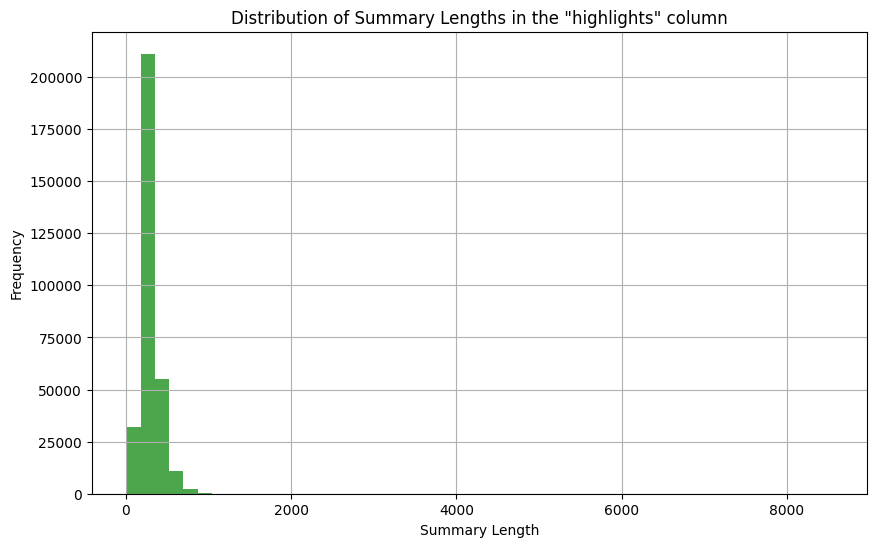

In [ ]:
# Compute the length of text for each entry in the 'highlights' column
df['summary_length'] = df['highlights'].apply(len)

# Plotting the distribution of summary lengths
plt.figure(figsize=(10,6))
plt.hist(df['summary_length'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Summary Lengths in the "highlights" column')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


In [ ]:
# IQR method
Q1 = df['summary_length'].quantile(0.25)
Q3 = df['summary_length'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['summary_length'] < (Q1 - 1.5 * IQR)) | (df['summary_length'] > (Q3 + 1.5 * IQR))]

In [ ]:
df_filtered2 = df[(df['summary_length'] >= (Q1 - 1.5 * IQR)) & (df['summary_length'] <= (Q3 + 1.5 * IQR))]

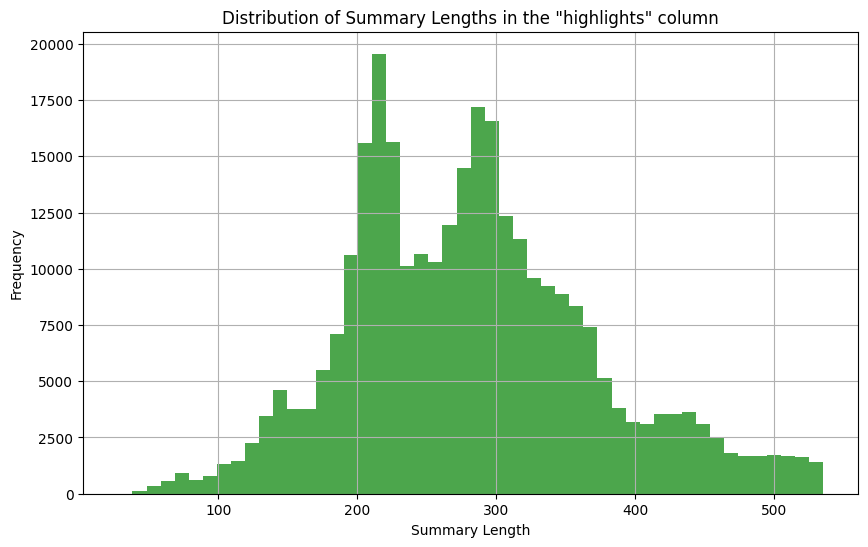

In [ ]:

# Plotting the distribution of summary lengths
plt.figure(figsize=(10,6))
plt.hist(df_filtered2['summary_length'], bins=50, color='green', alpha=0.7)
plt.title('Distribution of Summary Lengths in the "highlights" column')
plt.xlabel('Summary Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
# Count the total number of summaries
total_summaries = len(df['highlights'])

# Count the number of unique summaries
unique_summaries = len(df['highlights'].unique())

# Calculate the ratio of unique summaries to total summaries
unique_summaries_ratio = unique_summaries / total_summaries

# Print the ratio
print(f'The ratio of unique summaries to total summaries is {unique_summaries_ratio:.2f}')


The ratio of unique summaries to total summaries is 0.98


In [ ]:
# Count the total number of summaries
total_summaries = len(df_filtered['article'])

# Count the number of unique summaries
unique_summaries = len(df_filtered['article'].unique())

# Calculate the ratio of unique summaries to total summaries
unique_summaries_ratio = unique_summaries / total_summaries

# Print the ratio
print(f'The ratio of unique articles is {unique_summaries_ratio:.2f}')

The ratio of unique articles is 0.99


In [ ]:
df.shape

(311971, 5)

In [ ]:
df_filtered.shape

(304403, 4)

In [ ]:
df_filtered.head()

,article,highlights,split,article_length
0,"LONDON, England (Reuters) -- Harry Potter star...",Harry Potter star Daniel Radcliffe gets £20M f...,train,2527
1,Editor's note: In our Behind the Scenes series...,Mentally ill inmates in Miami are housed on th...,train,4051
2,"MINNEAPOLIS, Minnesota (CNN) -- Drivers who we...","NEW: ""I thought I was going to die,"" driver sa...",train,3940
3,WASHINGTON (CNN) -- Doctors removed five small...,"Five small polyps found during procedure; ""non...",train,2620
4,(CNN) -- The National Football League has ind...,"NEW: NFL chief, Atlanta Falcons owner critical...",train,5764


In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset, DatasetDict

# Group the DataFrame by the 'split' column
grouped = df_filtered.groupby('split')

# Create a DatasetDict
dataset_dict = DatasetDict({
    split: Dataset.from_pandas(group.drop(columns='split')) for split, group in grouped
})

# Now, 'dataset_dict' should have the desired structure


In [ ]:
dataset_dict

DatasetDict({
    test: Dataset({
        features: ['article', 'highlights', 'article_length', '__index_level_0__'],
        num_rows: 11185
    })
    train: Dataset({
        features: ['article', 'highlights', 'article_length', '__index_level_0__'],
        num_rows: 280158
    })
    validation: Dataset({
        features: ['article', 'highlights', 'article_length', '__index_level_0__'],
        num_rows: 13060
    })
})

In [ ]:
dataset_dict = dataset_dict.remove_columns(['article_length','__index_level_0__'])

In [ ]:
dataset_dict

DatasetDict({
    test: Dataset({
        features: ['article', 'highlights'],
        num_rows: 11185
    })
    train: Dataset({
        features: ['article', 'highlights'],
        num_rows: 280158
    })
    validation: Dataset({
        features: ['article', 'highlights'],
        num_rows: 13060
    })
})



*   Outliers can affect the learning process of summarization models. Extremely long texts might introduce noise or cause the model to learn irrelevant patterns.List item
*   Extremely long or short texts can be taxing on computational resources. Longer texts may require more memory and processing power to handle.
*   If the text length significantly varies, evaluating the performance of the summarization model might be challenging. The quality of summaries for shorter texts might be different from those for longer texts.



Output dataframe to CSV

In [ ]:
df_filtered.drop(columns=['split','article_length'], inplace=True)

<ipython-input-46-d6fcdc0ffe1f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop(columns=['split','article_length'], inplace=True)


In [ ]:
df_filtered.shape

(304403, 2)

In [ ]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304403 entries, 0 to 311970
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   article     304403 non-null  object
 1   highlights  304403 non-null  object
dtypes: object(2)
memory usage: 15.0+ MB


In [ ]:
# df_filtered
#----------------- Save merged dataset to CSV -----------------
from google.colab import files

## Use this to save dataset to CSV
df_filtered.to_csv('CNN_Dailymail.csv')
files.download('CNN_Dailymail.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>